# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection** 
***


## Functions

In [1]:
#Feature Extraction
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
%matplotlib inline
import matplotlib.pyplot as plt

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, flipImage = False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img_list = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        img_list.append(image)
        
        if flipImage:
            #flip image horizontally
            image = cv2.flip(image,1)
            img_list.append(image)
                            
        for image in img_list:
            file_features = []
            # apply color conversion if other than 'RGB'
            if color_space != 'RGB':
                if color_space == 'GRAY':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image)      

            if spatial_feat == True:
                spatial_features = bin_spatial(feature_image, size=spatial_size)
                file_features.append(spatial_features)
            if hist_feat == True and color_space !='GRAY':
                # Apply color_hist()
                hist_features = color_hist(feature_image, nbins=hist_bins)
                file_features.append(hist_features)
            if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
                if color_space =='GRAY':
                    hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                elif hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
            features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [170]:
#Train the classifier
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'GRAY':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True and color_space !='GRAY':
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if color_space =='GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL': 
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
images = glob.glob('./Training/vehicles/*/*.png')
cars = []
for image in images:
    cars.append(image)

print(np.shape(cars))
images = glob.glob('./Training/non-vehicles/*/*.png')
notcars = []
for image in images:
    notcars.append(image)
print(np.shape(notcars))


color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, flipImage=False)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, flipImage=False)

X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print(np.shape(X))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print(np.shape(y))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(penalty='l2')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

(8792,)
(8968,)


  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



(17760, 8460)
(17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
12.49 Seconds to train SVC...
Test Accuracy of SVC =  0.987


In [7]:
import pickle

data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }

with open('model-params.pk', 'wb') as pFile:
    pickle.dump(data, pFile)

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



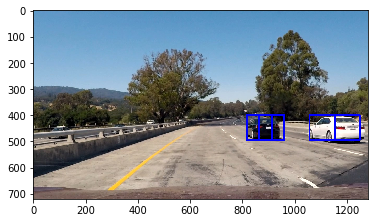

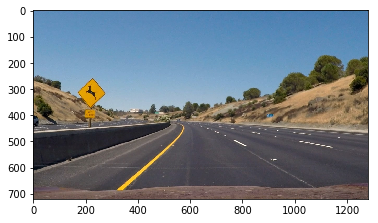

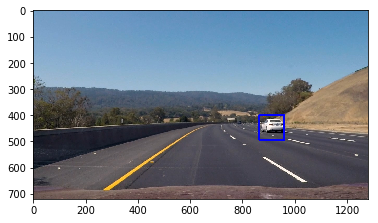

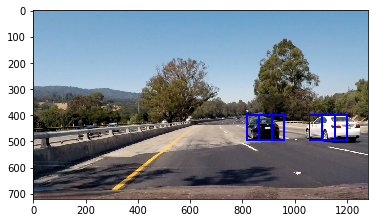

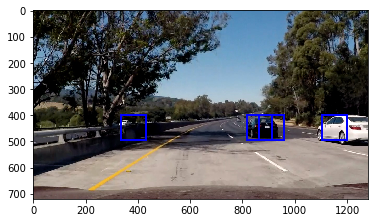

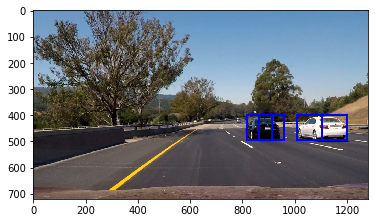

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt

images = glob.glob('./test_images/*.jpg')

for img in images:

    image = mpimg.imread(img)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    y_start_stop = [400,700]
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.figure()
    plt.imshow(window_img)
#plt.imshow(cv2.flip(image,1))


In [172]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bbox_list
    

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def dec_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



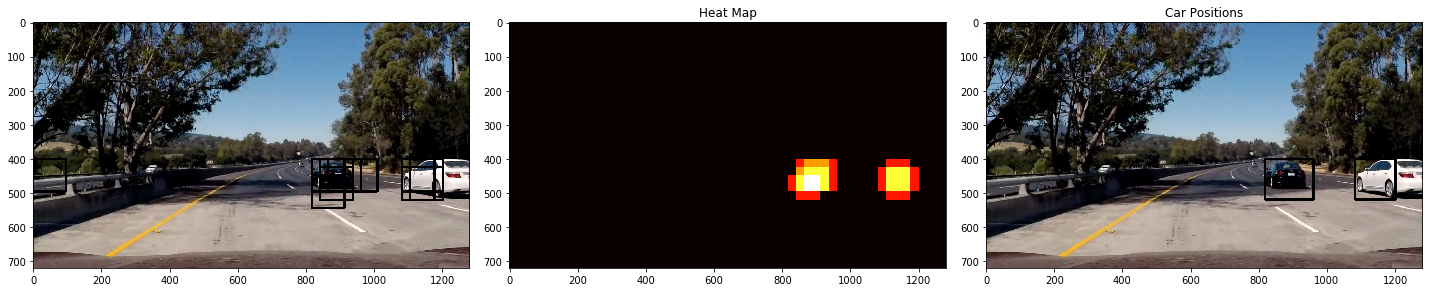

In [201]:
# Read in image similar to one shown above 
image = mpimg.imread('./test_images/test5.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
image = image.astype(np.float32)/255

ystart = 400
ystop = 656
scale = 1.5


out_img,box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#plt.imshow(out_img)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(out_img)
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(draw_img)
plt.title('Car Positions')
fig.tight_layout()

In [194]:
from collections import deque
from scipy.ndimage.measurements import label

class DetectVehicles:
    def __init__(self):
        self.ystart = []
        self.ystop  = []
        self.xstart = []
        self.xstop  = []
        self.scales = []
        self.svc = []
        self.X_scaler = []
        self.orient = 0
        self.pix_per_cell = 0
        self.cell_per_block = 0
        self.spatial_size = 0
        self.hist_bins = 0
        self.bbox_current = []
        self.bbox_old     = []
        self.heat_map_current = []
        self.count = 0
        self.history_length = 6
        self.history = []
        self.color_space = 'YCrCb'
        self.heatMapThresh = 5
        self.strucElement = np.ones((50, 50))
        self.full_process_interval = 2
        
        
    def SetClassifierVars(self, svc, X_scaler,color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,history_length,heatMapThresh):
        self.svc = svc
        self.X_scaler = X_scaler
        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.history_length = history_length
        self.heatMapThresh = heatMapThresh
    
    
    def SetScales(self,scales,ystart, ystop, xstart, xstop):
        self.scales = scales
        self.ystart = ystart
        self.ystop  = ystop
        self.xstart = xstart
        self.xstop  = xstop
        
        
    def convert_color(self,img, color_space):
        
        # Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)  
        
        return feature_image    

    # Define a function to return HOG features and visualization
    def get_hog_features(self,img, orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features

    # Define a function to compute binned color features  
    def bin_spatial(self,img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features

    # Define a function to compute color histogram features 
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(self,img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features


    def add_heat(self,heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes


    def dec_heat(self,heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes


    def apply_threshold(self,heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # heatmap[heatmap > threshold] = 1
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(self,img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            area = (bbox[1][0]-bbox[0][0])*(bbox[1][1]-bbox[0][1])
            
            if area > 2000:
                # Draw the box on the image
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,1), 6)
                #print(bbox,area)
                
        # Return the image
        return img

    #Define a single function that can extract features using hog sub-sampling and make predictions
    def get_detections(self,img,draw_img, scale, ystart, ystop, xstart, xstop):
        
        svc    = self.svc
        X_scaler = self.X_scaler
        orient  = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins

        #draw_img = np.copy(img)
        #img = img.astype(np.float32)/255
        
        ##get the mask to search
        #if self.count % self.full_process_interval == 0:
        #    mask = np.ones_like(img[:, :, 0])
        #else:
        #    #mask = np.sum(np.array(self.heat_map_current), axis=0).astype(np.uint8)
        #    mask = np.array(self.heat_map_current)
        #    mask[(mask > 0)] = 1
        #    mask = cv2.dilate(mask, self.strucElement, iterations=1)
#
        #nonzero = mask.nonzero()
        #nonzeroy = np.array(nonzero[0])
        #nonzerox = np.array(nonzero[1])
#
        #if len(nonzeroy) != 0:
        #    ystart = max(np.min(nonzeroy), ystart)
        #    ystop = min(np.max(nonzeroy), ystop)
        #if len(nonzerox) != 0:
        #    xstart = max(np.min(nonzerox), xstart)
        #    xstop = np.max(nonzerox)
        #
        #if xstop <= xstart or ystop <= ystart:
        #    return img,[]

        
        img_tosearch = img[ystart:ystop,xstart:xstop,:]
        ctrans_tosearch = self.convert_color(img_tosearch, self.color_space)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            #print(imshape)
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = self.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = self.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = self.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        bbox_list = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = self.bin_spatial(subimg, size=spatial_size)
                hist_features = self.color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = self.X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = self.svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

        return draw_img, bbox_list
    
    
    def find_cars(self,img,lane_img):
                
        if not np.any(self.history):
            self.history = deque([],maxlen = self.history_length)
        
       
        #Initialize the heat map if not already initialized
        #if not np.any(self.heat_map_current):
        heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
         
        result_img = np.copy(img)  
        for scale, ystart, ystop, xstart, xstop in zip (self.scales, self.ystart, self.ystop,self.xstart, self.xstop):
            result_img, box_list = self.get_detections(img,result_img,scale, ystart, ystop, xstart, xstop)
                
            # Add heat to each box in box list
            heat_map = self.add_heat(heat_map,box_list)
            
            # Threshold at the individual frame level
            # heat_map = self.apply_threshold(heat_map,1)
    
        #Add the current heat map to the queue
        self.history.appendleft(heat_map)
        
        #Find heat map for the current frame
        self.heat_map_current = np.zeros_like(img[:,:,0]).astype(np.float)
        
        for hm in self.history:
            self.heat_map_current+=hm
            
        # Apply threshold to help remove false positives
        heat_map_thresh = self.apply_threshold(self.heat_map_current,self.heatMapThresh)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat_map_thresh, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(lane_img, labels)

         #increment the frame counter
        self.count+=1
       
        return draw_img
        

In [199]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
xstart = [0,  0,    0]
xstop  = [1280,  1280, 1280 ]
ystart = [380,  400, 500 ]
ystop =  [480,  600, 700 ]
scales = [1, 1.5, 2]
history_length = 10
heatMapThresh  = 5

det = DetectVehicles()
det.SetClassifierVars(svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, history_length,heatMapThresh)
det.SetScales(scales,ystart, ystop, xstart, xstop)

cap = cv2.VideoCapture('project_video.mp4')
test_output = 'project_video_output_veh.mp4'

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(test_output,fourcc, 20.0, (1280,720),True)

count = 0
success = True
while success:
    success,frame = cap.read()
    if success:
        
                
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame.astype(np.float32)/255
               
        start = 0
        if count>=start:
            #print(count)
            result = det.find_cars(frame, frame)

            result = result*255
            result = result.astype(np.uint8)

            #outString = "Frame Num :{0:3d}".format(count+1)
            #cv2.putText(img = result, text = outString, org = (50,500), fontFace = cv2.FONT_HERSHEY_TRIPLEX , 
            #            fontScale = 1,color = (255, 255, 0))
               
            result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
            out.write(result)

    count = count+1
            
    print('.', end='', flush=True)
    if count%100 == 0:
        print(count)
    #if count >800:
    #    break
                           
cap.release()
out.release()
cv2.destroyAllWindows()


  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



....................................................................................................100
....................................................................................................200
....................................................................................................300
....................................................................................................400
....................................................................................................500
....................................................................................................600
....................................................................................................700
....................................................................................................800
....................................................................................................900
................................................................

In [200]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
    
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

## Lane detection

In [94]:
import glob

def find_calibration_parameters(calibration_dir):
    # prepare object points
    nx = 9
    ny = 6

    objectPoints = []
    imagePoints  = []
    
    objP = np.zeros((9*6,3),np.float32)
    objP[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    #find the files and iterate over them
    files = glob.glob(calibration_dir+"calibration*.jpg")
    
    fig = plt.figure(figsize=(20, 10))
    count = 0
    for file in files:
        
        #increment the count
        count+=1
        
        #print(file)
        img = cv2.imread(file)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
       # If found, draw corners
        if ret == True:
            imagePoints.append(corners)
            objectPoints.append(objP)
            
            #Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            ax = fig.add_subplot(5, 4, count)
            ax.imshow(img)
        else:
            ax = fig.add_subplot(5, 4, count)
            ax.imshow(np.zeros(img.shape))
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, gray.shape[::-1], None, None)
    return mtx, dist
        


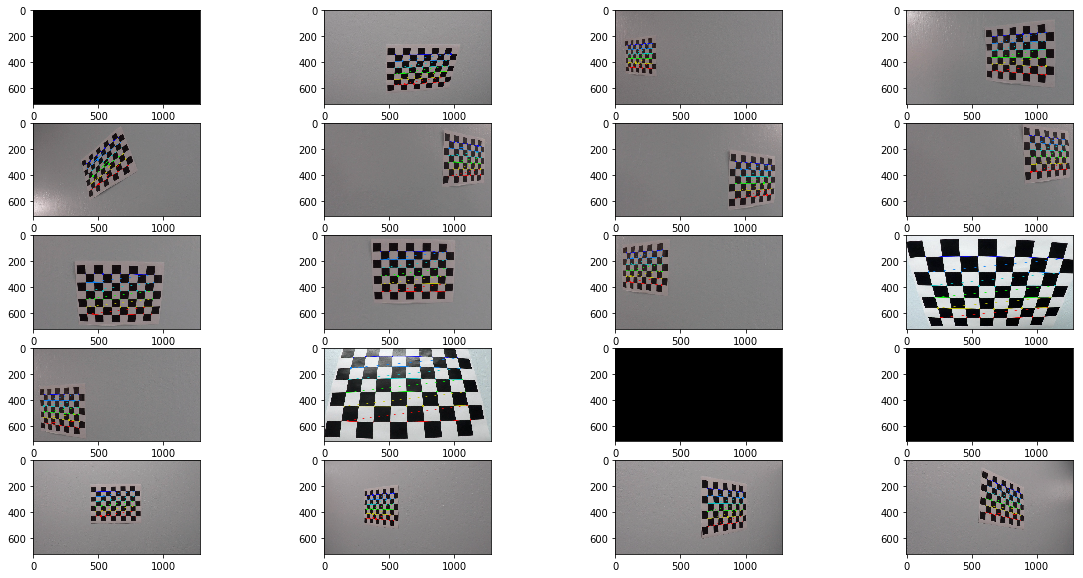

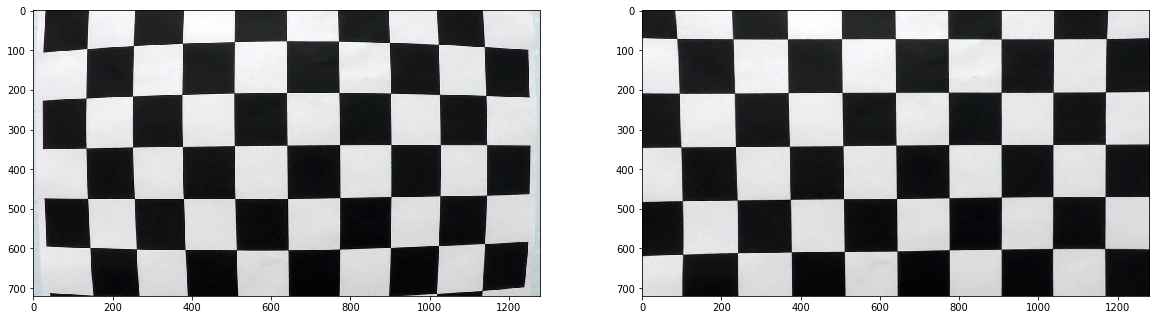

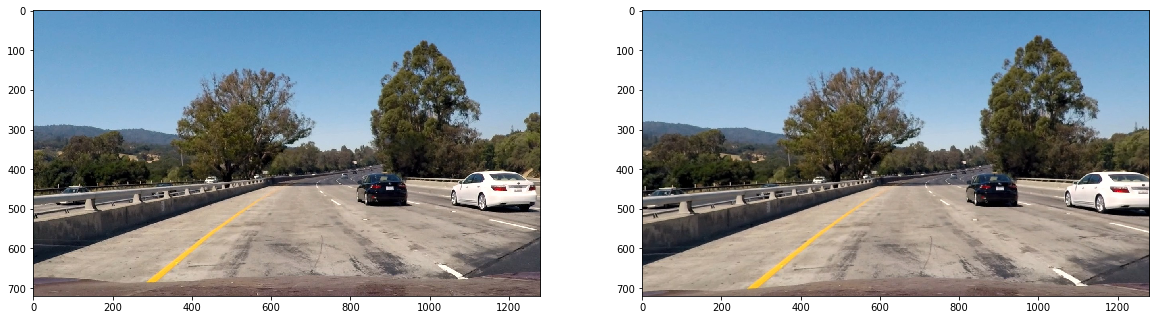

In [95]:
# Get the camera calibration paramters
mtx, dist = find_calibration_parameters('./camera_cal/')

img = cv2.imread('./camera_cal/calibration1.jpg')
undst = cv2.undistort(img, mtx, dist, None, mtx)
 
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(undst)

img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undst = cv2.undistort(img, mtx, dist, None, mtx)
 
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(undst)

In [96]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def warp_perspective(img):
    # Perspective Transform
    src = np.float32([(200, 720), (580, 480), (720, 480), (1050, 700)])
    dst = np.float32([(280, 720), (400, 190), (920, 190), (960, 720)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = img.shape
    warped = cv2.warpPerspective(img, M, img_size[1::-1], flags=cv2.INTER_LINEAR)
    return warped, M, Minv

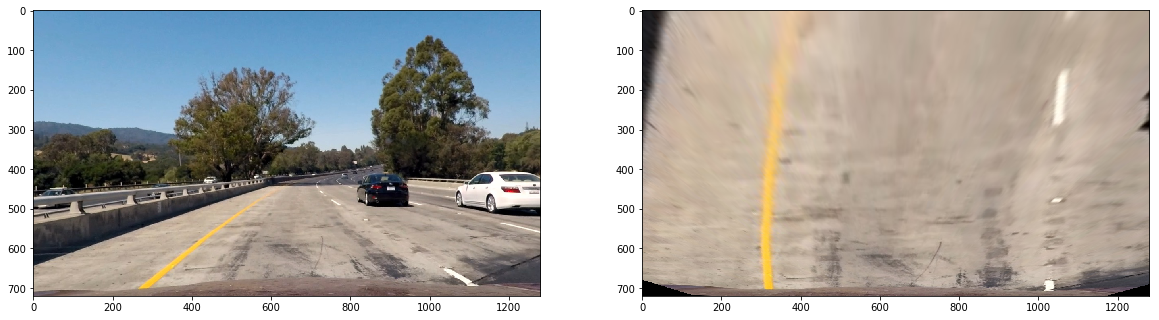

In [97]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undst = cv2.undistort(img, mtx, dist, None, mtx)
lane_persp_view,M,Minv = warp_perspective(img)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(undst)
plt.subplot(122)
plt.imshow(lane_persp_view)

In [ ]:
import cv2 

def plot_color_space(img, colorspace):
    
    color_t = getattr(cv2, 'COLOR_RGB2{}'.format(colorspace))
    resImage = cv2.cvtColor(img, color_t)
    
    plt.figure(figsize=(20, 10))
    plt.subplot(141)
    plt.imshow(img)
    plt.subplot(142)
    plt.imshow(resImage[:,:,0],cmap='gray')
    plt.title('{} Channel'.format(colorspace[0]))
    plt.subplot(143)
    plt.imshow(resImage[:,:,1],cmap='gray')
    plt.title('{} Channel'.format(colorspace[1]))
    plt.subplot(144)
    plt.imshow(resImage[:,:,2],cmap='gray')
    plt.title('{} Channel'.format(colorspace[2]))
    

# Read in and grayscale the image
image = mpimg.imread('test_images/test5.jpg')

#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lane_persp_view,M,Minv = warp_perspective(image)
        
plot_color_space(lane_persp_view,'HSV')
plot_color_space(lane_persp_view,'LAB')
plot_color_space(lane_persp_view,'HLS')


In [102]:
def threshold_color_space(img,colorspace,channel,threshold,cliplimit=2,plot_images=0):
    color_t = getattr(cv2, 'COLOR_RGB2{}'.format(colorspace))
    resImage = cv2.cvtColor(img, color_t)
    selectChannel = resImage[:,:,channel]
    
    # Normalize regions of the image using CLAHE
    clahe = cv2.createCLAHE(cliplimit, tileGridSize=(8, 8))
    norm_img = clahe.apply(selectChannel)
 
    # Threshold to binary
    ret, binary = cv2.threshold(norm_img, threshold, 1, cv2.THRESH_BINARY)
    
    # Adaptive threshold
    # binary = cv2.adaptiveThreshold(norm_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    #        cv2.THRESH_BINARY,51,-20)
    
    if plot_images:
        plt.figure(figsize=(20, 10))
        plt.subplot(141)
        plt.imshow(img)
        plt.subplot(142)
        plt.imshow(selectChannel,cmap='gray')
        plt.title('{} Channel'.format(colorspace[channel]))
        plt.subplot(143)
        plt.imshow(norm_img,cmap='gray')
        plt.title('Normalized channel')
        plt.subplot(144)
        plt.imshow(binary,cmap='gray')
        plt.title('Thresholded result')

        
    return binary

def find_lane_pixels(img, plot_images=0):

    # Perform binary thresholding according to each setting and combine them into one image.
    scores = np.zeros(img.shape[0:2]).astype('uint8')
    #scores += threshold_color_space(img,'HSV',2,230,plot_images=plot_images)
    scores += threshold_color_space(img,'LAB',2,150,plot_images=plot_images)
    scores += threshold_color_space(img,'HLS',1,180,plot_images=plot_images)
 
    result = cv2.normalize(scores, None, 0, 255, cv2.NORM_MINMAX)
    
    if plot_images:
        plt.figure(figsize=(20, 10))
        plt.subplot(141)
        plt.imshow(img)
        plt.subplot(142)
        plt.imshow(result,cmap='gray')
        plt.title('Lane pixels')

 
    return result

In [ ]:
# Read in and grayscale the image
image = mpimg.imread('test_images/test6.jpg')

# conver to the overhead view
lane_persp_view,M,Minv = warp_perspective(image)
        
#get the lane pixels
lane_pixels = find_lane_pixels(lane_persp_view,1)

   

## Build the Lane Finding Pipeline

In [126]:
class DetectLane:
    def __init__(self):
        self.mtx = []
        self.left_fit_gl=[]
        self.right_fit_gl=[]
        self.leftrad = []
        self.rightrad = []
        self.leftLaneEndingBot = []
        self.leftLaneEndingTop = []
        self.rightLaneEndingBot = []
        self.rightLaneEndingTop = []
        self.leftBotDash = []
        self.rightBotDash =[]
        self.bottomOffset = 10
        self.lineEndTol = 100
        self.curvTol    = 1000
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        self.left_fitx = []
        self.right_fitx = []
        self.alpha = 0.2
        

    def set_calibration_matrix(self,mtx):
        self.mtx = mtx
        return
    
    def warp_perspective(self,img):
        # Perspective Transform
        src = np.float32([(200, 720), (580, 480), (720, 480), (1050, 700)])
        dst = np.float32([(280, 720), (400, 190), (920, 190), (960, 720)])
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        img_size = img.shape
        warped = cv2.warpPerspective(img, M, img_size[1::-1], flags=cv2.INTER_LINEAR)
        return warped, M, Minv

    def threshold_color_space(self,img,colorspace,channel,threshold,cliplimit=2,plot_images=0):
        color_t = getattr(cv2, 'COLOR_RGB2{}'.format(colorspace))
        resImage = cv2.cvtColor(img, color_t)
        selectChannel = resImage[:,:,channel]

        # Normalize regions of the image using CLAHE
        clahe = cv2.createCLAHE(cliplimit, tileGridSize=(8, 8))
        norm_img = clahe.apply(selectChannel)

        # Threshold to binary
        ret, binary = cv2.threshold(norm_img, threshold, 1, cv2.THRESH_BINARY)

        # Adaptive threshold
        # binary = cv2.adaptiveThreshold(norm_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
        #        cv2.THRESH_BINARY,51,-20)

        if plot_images:
            plt.figure(figsize=(20, 10))
            plt.subplot(141)
            plt.imshow(img)
            plt.subplot(142)
            plt.imshow(selectChannel,cmap='gray')
            plt.title('{} Channel'.format(colorspace[channel]))
            plt.subplot(143)
            plt.imshow(norm_img,cmap='gray')
            plt.title('Normalized channel')
            plt.subplot(144)
            plt.imshow(binary,cmap='gray')
            plt.title('Thresholded result')


        return binary

    def find_lane_pixels(self,img, plot_images=0):

        # Perform binary thresholding according to each setting and combine them into one image.
        scores = np.zeros(img.shape[0:2]).astype('uint8')
        #scores += threshold_color_space(img,'HSV',2,230,plot_images=plot_images)
        scores += threshold_color_space(img,'LAB',2,150,plot_images=plot_images)
        scores += threshold_color_space(img,'HLS',1,210,plot_images=plot_images)

        result = cv2.normalize(scores, None, 0, 255, cv2.NORM_MINMAX)

        if plot_images:
            plt.figure(figsize=(20, 10))
            plt.subplot(141)
            plt.imshow(img)
            plt.subplot(142)
            plt.imshow(result,cmap='gray')
            plt.title('Lane pixels')
            
        return result

    def find_lanes(self,binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        startY = np.int(binary_warped.shape[0]*1/2)
        histogram = np.sum(binary_warped[startY:,:], axis=0)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines

        midpoint = np.int(histogram.shape[0]/2)
        startX = np.int(binary_warped.shape[1]*0.1)
        leftx_base = np.argmax(histogram[startX:midpoint])+startX
        rightx_base = np.argmax(histogram[midpoint:binary_warped.shape[1]-startX]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 2) 
            else:
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,255), 2)
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 2)
            else:
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,255), 2)
            

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

         # Fit a second order polynomial to each
        left_fit=[]
        right_fit=[]
        if np.any(lefty) and np.any(leftx):
            left_fit = np.polyfit(lefty, leftx , 2)

        if np.any(righty) and np.any(rightx):    
            right_fit = np.polyfit(righty, rightx , 2)

        #Put the detected lane points in the output image
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        #Put the fitted lanes in the output image
        ploty = np.linspace(0, 719, num=720)
        for y in ploty:
            xLeft = np.int(left_fit[0]*y**2 + left_fit[1]*y + left_fit[2])
            xRight = np.int(right_fit[0]*y**2 + right_fit[1]*y + right_fit[2])
            if xLeft>=0 and xLeft<binary_warped.shape[1]:
                out_img[np.int(y),xLeft,:]  = [255, 255, 0]
            if xRight>=0 and xRight<binary_warped.shape[1]:
                out_img[np.int(y),xRight,:] = [255, 255, 0]
        
        return out_img.astype(np.uint8),left_fit,right_fit, leftx, lefty, rightx, righty


    def find_lanes_tracking(self,binary_warped,left_fit,right_fit):

        #print("Inside lanes tracking")

        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 50
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

         # Fit a second order polynomial to each
        left_fit=[]
        right_fit=[]
        left_fitx =[]
        right_fitx=[]
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        if np.any(lefty) and np.any(leftx):
            left_fit = np.polyfit(lefty, leftx , 2)
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        if np.any(righty) and np.any(rightx):    
            right_fit = np.polyfit(righty, rightx , 2)
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        ploty = np.linspace(0, 719, num=720)
        if np.any(left_fitx):
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            for y in ploty:
                xLeft = np.int(left_fit[0]*y**2 + left_fit[1]*y + left_fit[2])
                if xLeft>=0 and xLeft<binary_warped.shape[1]:
                    out_img[np.int(y),xLeft,:]  = [255, 255, 0]
       
            
        if np.any(right_fitx):    
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            for y in ploty:
                xRight = np.int(right_fit[0]*y**2 + right_fit[1]*y + right_fit[2])
                if xRight>=0 and xRight<binary_warped.shape[1]:
                    out_img[np.int(y),xRight,:] = [255, 255, 0]
        
        
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        #Put the fitted lanes in the output image
        
        

        return result.astype(np.uint8),left_fit,right_fit, leftx, lefty, rightx, righty

    def get_curvature(self,xpoints, ypoints):

        # Get conversions in x and y from pixels space to meters
        ym_per_pix = self.ym_per_pix
        xm_per_pix = self.xm_per_pix

        ploty = np.linspace(0, 719, num=720)

        # Fit a second order polynomial to each
        fit_cr = np.polyfit(ypoints*ym_per_pix, xpoints*xm_per_pix , 2)

        y_eval = np.max(ploty)
        # Calculate the new radii of curvature
        curverad =  ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

        return curverad
   
    def get_position(self, x_bot_left,x_bot_right,shape):
        # Get conversions in x and y from pixels space to meters
        ym_per_pix = self.ym_per_pix
        xm_per_pix = self.xm_per_pix

        left_bot_x = x_bot_left*xm_per_pix
        right_bot_x = x_bot_right*xm_per_pix
        offset = shape[1]/2*xm_per_pix - (left_bot_x+right_bot_x)/2
        return offset
        
        
    def create_result_image(self,undist,warped,left_fitx,right_fitx,M,Minv):
        height = undist.shape[0]-self.bottomOffset
        ploty = np.linspace(0, height-1, num=height)

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        #for debugging
        #undistWarp = cv2.warpPerspective(undist, M, (image.shape[1], image.shape[0])) 
        #result = cv2.addWeighted(undistWarp, 1, color_warp, 0.3, 0)
        return result


    def create_composite_image(self,img, lane_img, lane_persp_view, lane_track_img):
        img_size = img.shape
        result   = np.zeros([np.int(img_size[0]*3/2),img_size[1],img_size[2]])

        result[np.int(img_size[0]/2):np.int(img_size[0]*3/2),:,:] = img
        resX = np.int(img_size[1]/3)
        resY = np.int(img_size[0]/2)

        #resized_image = cv2.resize(lane_img, (resX, resY)) 
        #left_top = np.dstack((resized_image,resized_image,resized_image))
        #result[0:resY,0:resX,:] = left_top.astype(np.uint8)

        left_top = cv2.resize(lane_img, (resX, resY)) 
        result[0:resY,0:resX,:] = left_top.astype(np.uint8)

        resized_image = cv2.resize(lane_persp_view, (resX, resY)) 
        middle_top = np.dstack((resized_image,resized_image,resized_image))
        result[0:resY,resX:2*resX,:] = middle_top.astype(np.uint8)

        resXNew = img_size[1]-2*resX
        right_top = cv2.resize(lane_track_img,(resXNew,resY))
        result[0:resY,2*resX:img_size[1],:] = right_top

        return result.astype(np.uint8)

    
    def process_image(self, image):
        # Undistort the image
        #image_undst = cv2.undistort(image, self.mtx, dist, None, mtx)
        image_undst = image
        
        #Define a kernel size and apply Gaussian smoothing
        #kernel_size = 5
        #blur_image = self.gaussian_blur(image_undst,kernel_size)
        blur_image = image_undst
        
        lane_persp_view,M,Minv = self.warp_perspective(blur_image)
        lane_persp_view_seg  =  self.find_lane_pixels(lane_persp_view)
        
        if np.any(self.left_fit_gl):
            out_img,left_fit,right_fit,leftx, lefty, rightx, righty = self.find_lanes_tracking(lane_persp_view_seg,self.left_fit_gl,self.right_fit_gl)
        else:
            out_img,left_fit,right_fit,leftx, lefty, rightx, righty = self.find_lanes(lane_persp_view_seg)

        #out_img,left_fit,right_fit,leftx, lefty, rightx, righty = self.find_lanes(lane_persp_view_seg)
    
        dashy = image.shape[0]
        if np.any(left_fit):
            ploty = np.linspace(0, lane_persp_view_seg.shape[0]-self.bottomOffset-1, lane_persp_view.shape[0]-self.bottomOffset )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            left_bot_x = left_fitx[-1]
            left_top_x = left_fitx[0]
            left_bot_dash = left_fit[0]*dashy**2 + left_fit[1]*dashy + left_fit[2]
            leftrad = self.get_curvature(leftx, lefty) 
            
            #print("Left:",abs(self.leftrad-leftrad))
            if self.leftLaneEndingBot:
                if abs(left_bot_x-self.leftLaneEndingBot)<self.lineEndTol and abs(left_top_x-self.leftLaneEndingTop)<self.lineEndTol :
                    self.leftLaneEndingBot = left_bot_x
                    self.leftLaneEndingTop = left_top_x
                    self.left_fit_gl = left_fit
                    self.leftrad = leftrad   
                    self.leftBotDash = left_bot_dash
            else:
                self.leftLaneEndingBot = left_bot_x
                self.leftLaneEndingTop = left_top_x
                self.left_fit_gl = left_fit
                self.leftrad = leftrad   
                self.leftBotDash = left_bot_dash
        
        if np.any(right_fit):
            ploty = np.linspace(0, lane_persp_view_seg.shape[0]-self.bottomOffset-1, lane_persp_view_seg.shape[0]-self.bottomOffset )
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            right_bot_x = right_fitx[-1]
            right_top_x = right_fitx[0]
            rightrad = self.get_curvature(rightx, righty) 
            right_bot_dash = right_fit[0]*dashy**2 + right_fit[1]*dashy + right_fit[2]
            
            #print("Right:",right_bot_x)
            if self.rightLaneEndingBot:
                if abs(right_bot_x-self.rightLaneEndingBot)<self.lineEndTol and abs(right_top_x-self.rightLaneEndingTop)<self.lineEndTol :
                    self.rightLaneEndingBot = right_bot_x
                    self.rightLaneEndingTop = right_top_x
                    self.right_fit_gl = right_fit
                    self.rightrad = rightrad 
                    self.rightBotDash = right_bot_dash
            else:
                self.rightLaneEndingBot = right_bot_x
                self.rightLaneEndingTop = right_top_x
                self.right_fit_gl = right_fit
                self.rightrad = rightrad
                self.rightBotDash = right_bot_dash
        
        #print(self.left_fit_gl)
        
        #Get the lane fits for the current image
        ploty = np.linspace(0, lane_persp_view.shape[0]-self.bottomOffset-1, lane_persp_view.shape[0]-self.bottomOffset )
        left_fitx = self.left_fit_gl[0]*ploty**2 + self.left_fit_gl[1]*ploty + self.left_fit_gl[2]
        right_fitx = self.right_fit_gl[0]*ploty**2 + self.right_fit_gl[1]*ploty + self.right_fit_gl[2]
        
        
        #if any(self.left_fitx):
        #    l1 = [self.alpha*x for x in self.left_fitx]
        #    l2 = [(1-self.alpha)*x for x in self.left_fitx] 
        #    self.left_fitx = np.array(l1)+np.array(l2)
        #else:
        #    self.left_fitx = np.array(left_fitx)
        #    self.right_fitx = np.array(right_fitx)
            
        
        #Create the result image
        result = self.create_result_image(image_undst,lane_persp_view_seg,left_fitx,right_fitx,M,Minv)
        compImage = self.create_composite_image(result, lane_persp_view, lane_persp_view_seg, out_img)
        self.offset = self.get_position(self.leftBotDash,self.rightBotDash,result.shape)
        
        return result, image_undst, self.leftrad, self.rightrad, self.offset

## Project Video

In [197]:
import numpy as np
import cv2


color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
xstart = [0,  0,    0]
xstop  = [1280,  1280, 1280 ]
ystart = [380,  400, 500 ]
ystop =  [480,  600, 700 ]
scales = [1, 1.5, 2]
history_length = 10
heatMapThresh  = 5

det = DetectVehicles()
det.SetClassifierVars(svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, history_length,heatMapThresh)
det.SetScales(scales,ystart, ystop, xstart, xstop)

detLane = DetectLane()
detLane.set_calibration_matrix(mtx)


cap = cv2.VideoCapture('project_video.mp4')
test_output = 'project_video_output.mp4'

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(test_output,fourcc, 20.0, (1280,720),True)

#instantiate the detection object

count = 0
success = True
while success:
    success,frame = cap.read()
    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        laneRes, undst, leftrad, rightrad, offset = detLane.process_image(frame)
        frame = undst.astype(np.float32)/255
        laneRes = laneRes.astype(np.float32)/255
        result = det.find_cars(frame,laneRes)

        result = result*255
        result = result.astype(np.uint8)
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        out.write(result)
    
    count = count+1
    
    print('.', end='', flush=True)
    if count%100 == 0:
        print(count)
    #if count>100:
    #    break
                
cap.release()
out.release()
cv2.destroyAllWindows()

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



....................................................................................................100
....................................................................................................200
....................................................................................................300
....................................................................................................400
....................................................................................................500
....................................................................................................600
....................................................................................................700
....................................................................................................800
....................................................................................................900
................................................................

In [198]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
    
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))